# Sketch to Face Forensics - Data Preprocessing

This notebook implements the data preprocessing pipeline for a sketch-to-face translation system. The system converts hand-drawn sketches to photorealistic face images using deep learning techniques, primarily for forensic applications.

## Overview
- Load sketch and face image datasets
- Apply data augmentation to increase dataset size
- Save processed data for model training
- Visualize sample data pairs

## Technical Details
- Uses Python with TensorFlow/Keras for deep learning
- Implements custom data augmentation to increase dataset size
- Processes images to normalize pixel values (0-255 to 0-1 range)
- Creates a substantial dataset through augmentation (3008 real images and 3008 sketch images from original 188 pairs)

## Application
- Forensic investigations: Converting witness sketches to realistic images
- Law enforcement: Enhancing identification capabilities
- Research: Advancing image-to-image translation techniques

## Requirements
- TensorFlow 2.x
- TensorFlow Hub
- OpenCV
- NumPy
- Matplotlib
- Google Colab with GPU runtime (recommended)

## Dataset Structure
- Input: Hand-drawn sketches (grayscale)
- Output: Photorealistic face images (RGB)
- Resolution: 256x256 pixels

## Model Architecture
- Based on image-to-image translation techniques
- Uses deep convolutional neural networks
- Optimized for facial feature preservation

In [15]:
# 📁 File System Operations
import os                     # Operating system interfaces for file handling

# 🖼️ Image Processing Libraries
try:
    import cv2                # OpenCV for computer vision operations
except ImportError:
    !pip install opencv-python
    import cv2
    
import numpy as np            # NumPy for numerical operations on arrays

try:
    import matplotlib.pyplot as plt # Visualization and plotting
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# ⚙️ Utilities
try:
    from tqdm import tqdm     # Progress bars for loops
except ImportError:
    !pip install tqdm
    from tqdm import tqdm
    
import re                     # Regular expressions for pattern matching
import random                 # Random number generation for data augmentation

# 🧠 Deep Learning Framework
try:
    import tensorflow as tf   # Core deep learning library
    import tensorflow_hub as hub  # Pre-trained model repository
    from keras.preprocessing.image import img_to_array  # Image preprocessing
except ImportError:
    !pip install tensorflow tensorflow-hub
    import tensorflow as tf
    import tensorflow_hub as hub
    try:
        from keras.preprocessing.image import img_to_array
    except ImportError:
        from tensorflow.keras.preprocessing.image import img_to_array

# 📊 Display Utilities
from IPython.display import Image  # Display images in notebook

In [8]:
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.19.0
TF Hub version: 0.16.1
GPU not available :(


In [12]:
# 🔢 Set random seed for reproducibility
SEED = 42                # Fixed seed ensures consistent results across runs
tf.random.set_seed(SEED) # Apply seed to TensorFlow operations

In [2]:
# 📏 Configuration parameters for image processing
SIZE = 256                # Target image size (256x256 pixels)

# Define paths with error checking
img_path = '/content/drive/MyDrive/sketch-to-face-dataset/photos'    # 📸 Path to real face photos
sketch_path = '/content/drive/MyDrive/sketch-to-face-dataset/sketches'  # 🖌️ Path to sketch images

# Verify paths exist
if not os.path.exists(img_path):
    print(f"⚠️ Warning: Image path '{img_path}' does not exist. Please check the path.")
    # Create directory if it doesn't exist
    os.makedirs(img_path, exist_ok=True)
    print(f"Created directory: {img_path}")
    
if not os.path.exists(sketch_path):
    print(f"⚠️ Warning: Sketch path '{sketch_path}' does not exist. Please check the path.")
    # Create directory if it doesn't exist
    os.makedirs(sketch_path, exist_ok=True)
    print(f"Created directory: {sketch_path}")

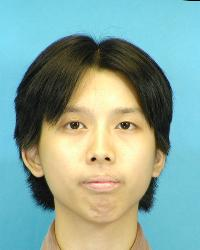

In [10]:
Image('/content/drive/MyDrive/sketch-to-face-dataset/photos/f-007-01.jpg')

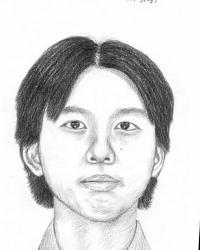

In [11]:
Image('/content/drive/MyDrive/sketch-to-face-dataset/sketches/F2-007-01-sz1.jpg')

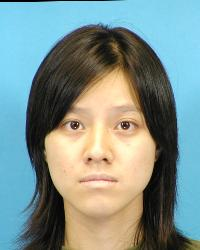

In [13]:
Image('/content/drive/MyDrive/sketch-to-face-dataset/photos/f-017-01.jpg')

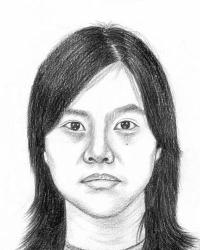

In [14]:
Image('/content/drive/MyDrive/sketch-to-face-dataset/sketches/F2-017-01-sz1.jpg')

In [3]:
# 🗄️ Initialize data storage arrays
img_array = []      # 📸 Will store processed face images
sketch_array = []   # 🖌️ Will store processed sketch images

In [4]:
def sorted_alphanumeric(data):
    """Sort filenames properly."""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [5]:
img_files = sorted_alphanumeric(os.listdir(img_path))
sketch_files = sorted_alphanumeric(os.listdir(sketch_path))

print(f"Found {len(img_files)} real images.")
print(f"Found {len(sketch_files)} sketches.")

Found 188 real images.
Found 188 sketches.


In [6]:
def load_and_preprocess_image(filepath, size=256):
    """Load, resize image (no normalization yet)."""
    try:
        # Check if file exists before attempting to read
        if not os.path.exists(filepath):
            print(f"Error: File does not exist: {filepath}")
            return None
            
        image = cv2.imread(filepath)
        if image is None:
            print(f"Warning: Unable to load image {filepath}")
            return None
            
        # Convert color space
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting color space for {filepath}: {str(e)}")
            return None
            
        # Resize image
        try:
            image = cv2.resize(image, (size, size))
        except Exception as e:
            print(f"Error resizing image {filepath}: {str(e)}")
            return None
            
        return image
    except Exception as e:
        print(f"Unexpected error processing {filepath}: {str(e)}")
        return None

In [16]:
# 🔄 Data Augmentation Function
def augment_image(image, num_augments=16):
    """Apply multiple augmentations to generate more variations."""
    try:
        # Check if input image is valid
        if image is None or not isinstance(image, np.ndarray):
            print("Error: Invalid image input to augment_image function")
            return []
            
        aug_list = []

        # --- 🔁 Geometric augmentations ---
        try:
            # These transformations preserve the content while changing orientation
            aug_list.append(image)                                    # Original image
            aug_list.append(cv2.flip(image, 1))                       # 🪞 Horizontal flip
            aug_list.append(cv2.flip(image, 0))                       # 🔃 Vertical flip
            aug_list.append(cv2.flip(cv2.flip(image, 0), 1))          # 🔄 H + V flip
            aug_list.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))         # ↩️ 90° rotation
            aug_list.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))  # ↪️ -90° rotation
            aug_list.append(cv2.rotate(image, cv2.ROTATE_180))                  # 🔃 180° rotation
        except Exception as e:
            print(f"Error during geometric augmentations: {str(e)}")
            # Continue with other augmentations even if these fail

        # --- 🎨 Photometric augmentations (brightness/contrast changes) ---
        try:
            # These transformations alter the visual appearance while preserving content
            for _ in range(5):
                img = image.copy().astype(np.float32)
                alpha = random.uniform(0.8, 1.2)  # ☀️ contrast factor
                beta = random.uniform(-30, 30)    # 💡 brightness shift
                img = np.clip(alpha * img + beta, 0, 255).astype(np.uint8)
                aug_list.append(img)
        except Exception as e:
            print(f"Error during photometric augmentations: {str(e)}")
            # Continue with other augmentations even if these fail

        # --- 🌫️ Noise and blur variations ---
        try:
            # Adding random noise and blur to simulate different image qualities
            for _ in range(4):
                img = image.copy().astype(np.float32)
                noise = np.random.normal(0, 10, img.shape)  # ✨ Random noise
                img = np.clip(img + noise, 0, 255).astype(np.uint8)
                if random.random() < 0.5:  # 50% chance of applying blur
                    img = cv2.GaussianBlur(img, (3, 3), 0)  # 🔍 Gaussian blur
                aug_list.append(img)
        except Exception as e:
            print(f"Error during noise/blur augmentations: {str(e)}")
            # Continue with other augmentations even if these fail

        # --- 📊 Limit to num_augments if too many ---
        if len(aug_list) > num_augments:
            aug_list = random.sample(aug_list, num_augments)
        elif len(aug_list) == 0:
            print("Warning: No augmentations were successful, returning original image")
            # Return at least the original image if possible
            try:
                return [img_to_array(image.astype('float32') / 255.0)]
            except:
                print("Error: Could not process original image")
                return []

        # Normalize all
        try:
            return [img_to_array(img.astype('float32') / 255.0) for img in aug_list]
        except Exception as e:
            print(f"Error during normalization: {str(e)}")
            # Try to return unnormalized images as a fallback
            return aug_list
            
    except Exception as e:
        print(f"Unexpected error in augment_image: {str(e)}")
        return []

In [17]:
# 📊 Set augmentation count
NUM_AUGMENTS = 16  # 🔄 Number of variations to generate per image

In [18]:
# 🖼️ Load and Process Images
# Load and augment real images
for filename in tqdm(img_files, desc="Loading and Augmenting Real Images"):
    img_fp = os.path.join(img_path, filename)  # 📁 Create full file path
    image = load_and_preprocess_image(img_fp, size=SIZE)  # 🔍 Load and resize
    if image is None:  # ⚠️ Skip invalid images
        continue
    augmented_images = augment_image(image, num_augments=NUM_AUGMENTS)  # 🔄 Create variations
    img_array.extend(augmented_images)  # 📥 Add to dataset


# 🖌️ Load and Process Sketches
# Load and augment sketch images (same augmentations)
for filename in tqdm(sketch_files, desc="Loading and Augmenting Sketch Images"):
    sketch_fp = os.path.join(sketch_path, filename)  # 📁 Create full file path
    sketch = load_and_preprocess_image(sketch_fp, size=SIZE)  # 🔍 Load and resize
    if sketch is None:  # ⚠️ Skip invalid images
        continue
    augmented_sketches = augment_image(sketch, num_augments=NUM_AUGMENTS)  # 🔄 Create variations
    sketch_array.extend(augmented_sketches)  # 📥 Add to dataset

Loading and Augmenting Sketch Images: 100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


In [19]:
# 📊 Dataset Statistics
print(f"Total number of real images: {len(img_array)}")  # 🖼️ Count of processed face images
print(f"Total number of sketch images: {len(sketch_array)}")  # 🖌️ Count of processed sketch images

Total number of real images: 3008
Total number of sketch images: 3008


In [20]:
# ✅ Data Validation
# Ensure counts match
assert len(img_array) == len(sketch_array), "Mismatch between real and sketch image counts!"  # 🔍 Verify dataset integrity

In [21]:
# 💾 Save Processed Data
np.save('/content/drive/MyDrive/sketch-to-face-dataset/CodeSaveData/real_images.npy', np.array(img_array))  # 🖼️ Save face images
np.save('/content/drive/MyDrive/sketch-to-face-dataset/CodeSaveData/sketch_images.npy', np.array(sketch_array))  # 🖌️ Save sketch images
print("Arrays saved successfully!")

Arrays saved successfully!


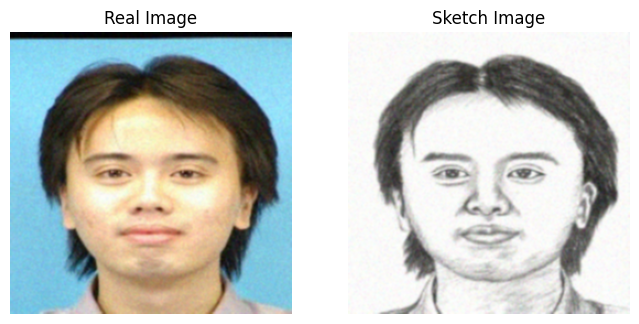

In [22]:
# 📊 Visualization Function
def plot_images(real_img, sketch_img):
    plt.figure(figsize=(8, 4))  # 📏 Set figure size
    plt.subplot(1, 2, 1)  # 🖼️ First subplot for real image
    plt.imshow(real_img)
    plt.title('Real Image')
    plt.axis('off')  # ❌ Hide axes

    plt.subplot(1, 2, 2)  # 🖌️ Second subplot for sketch image
    plt.imshow(sketch_img)
    plt.title('Sketch Image')
    plt.axis('off')  # ❌ Hide axes
    plt.show()

# 🔄 Example: Display Random Sample
idx = np.random.randint(0, len(img_array))  # 🎲 Select random index
plot_images(img_array[idx], sketch_array[idx])  # 📊 Display comparison

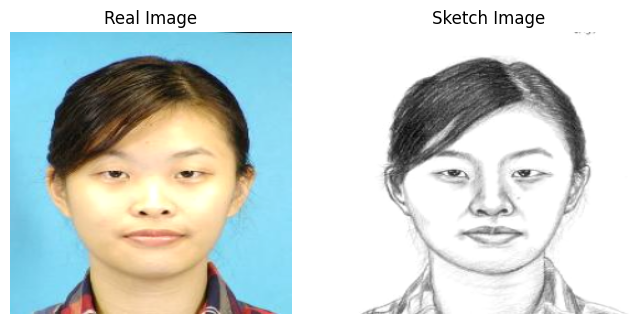

In [23]:
idx = np.random.randint(0, len(img_array))
plot_images(img_array[idx], sketch_array[idx])

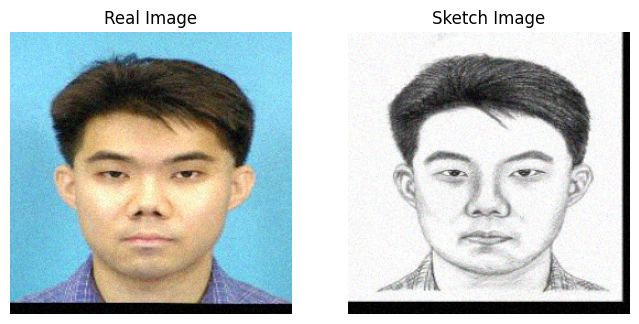

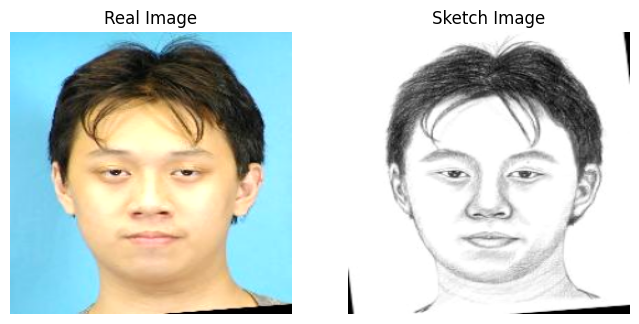

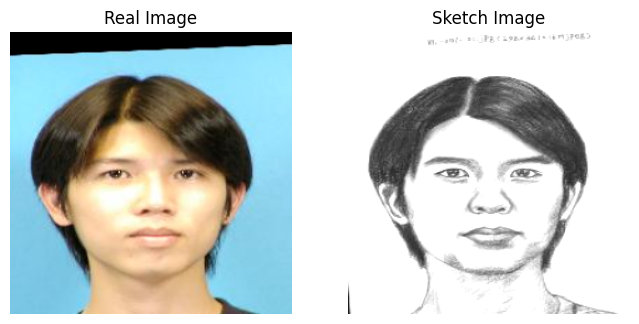

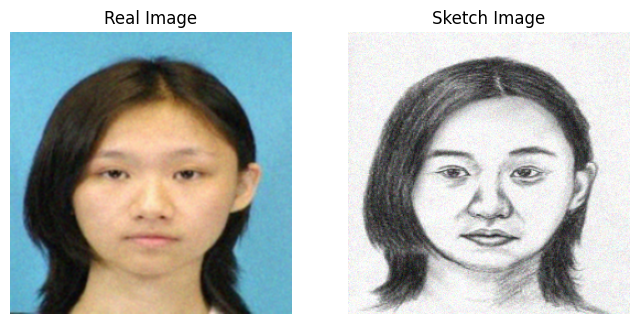

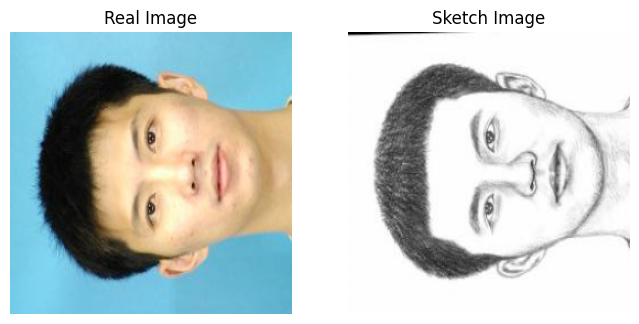

In [24]:
for i in range(5):
  idx = np.random.randint(0, len(img_array))
  plot_images(img_array[idx], sketch_array[idx])